In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
states_dict = {
        'AK': ['Alaska', 3],
        'AL': ['Alabama', 9],
        'AR': ['Arkansas', 6],
        'AZ': ['Arizona', 11],
        'CA': ['California', 55],
        'CO': ['Colorado', 9],
        'CT': ['Connecticut', 7],
        'DC': ['District of Columbia', 3],
        'DE': ['Delaware', 3],
        'FL': ['Florida', 29],
        'GA': ['Georgia', 16],
        'HI': ['Hawaii', 4],
        'IA': ['Iowa', 6],
        'ID': ['Idaho', 4],
        'IL': ['Illinois', 20],
        'IN': ['Indiana', 11],
        'KS': ['Kansas', 6],
        'KY': ['Kentucky', 8],
        'LA': ['Louisiana', 8],
        'MA': ['Massachusetts', 11],
        'MD': ['Maryland', 10],
        'ME': ['Maine', 4],
        'MI': ['Michigan', 16],
        'MN': ['Minnesota', 10],
        'MO': ['Missouri', 10],
        'MS': ['Mississippi', 6],
        'MT': ['Montana', 3],
        'NC': ['North Carolina', 15],
        'ND': ['North Dakota', 3],
        'NE': ['Nebraska', 5],
        'NH': ['New Hampshire', 4],
        'NJ': ['New Jersey', 14],
        'NM': ['New Mexico', 5],
        'NV': ['Nevada', 6],
        'NY': ['New York', 29],
        'OH': ['Ohio', 18],
        'OK': ['Oklahoma', 7],
        'OR': ['Oregon', 7],
        'PA': ['Pennsylvania', 20],
        'RI': ['Rhode Island', 4],
        'SC': ['South Carolina', 9],
        'SD': ['South Dakota', 3],
        'TN': ['Tennessee', 11],
        'TX': ['Texas' ,38],
        'UT': ['Utah', 6],
        'VA': ['Virginia', 13],
        'VT': ['Vermont', 3],
        'WA': ['Washington', 12],
        'WI': ['Wisconsin', 10],
        'WV': ['West Virginia', 5],
        'WY': ['Wyoming', 3]
}

states = pd.DataFrame.from_dict(states_dict, orient='index').reset_index()
states.columns = ['state_abbr', 'state', 'ev']


## 2020

In [149]:
poll2020 = pd.read_csv('../data/raw/president_polls2.csv', parse_dates=['start_date'], 
                  usecols=['state', 'pollster', 'sample_size', 'start_date',  'candidate_party', 'pct'])
poll2020 = poll2020[(poll2020.candidate_party == 'DEM') | (poll2020.candidate_party == 'REP')  ]
poll2020['state'] = poll2020['state'].fillna('USA')

poll2020['state'] = poll2020['state'].str.replace('Nebraska CD-2', 'Nebraska')
poll2020['state'] = poll2020['state'].str.replace('Nebraska CD-1', 'Nebraska')
poll2020['state'] = poll2020['state'].str.replace('Maine CD-1', 'Maine')
poll2020['state'] = poll2020['state'].str.replace('Maine CD-2', 'Maine')

poll2020 = poll2020[poll2020.start_date > '2020-01-01']
poll2020['sum_sample'] = poll2020.groupby(['state', 'candidate_party'])['sample_size'].transform('sum')

poll2020['weight'] = poll2020['sample_size'] / poll2020['sum_sample']
poll2020['weighted_pct'] = poll2020['pct']*poll2020['weight']
# poll2020['moe'] = 1.96*np.sqrt(poll2020['pct']*(100-poll2020['pct'])/poll2020['sample_size'])*poll2020['weight']

In [150]:
poll2020.head()

,state,pollster,sample_size,start_date,candidate_party,pct,sum_sample,weight,weighted_pct
0,USA,Ipsos,1115,2020-07-27,DEM,57.0,2717869,0.000410,0.023384
1,USA,Ipsos,1115,2020-07-27,REP,43.0,2717869,0.000410,0.017641
2,USA,Ipsos,947,2020-07-27,DEM,57.0,2717869,0.000348,0.019861
3,USA,Ipsos,947,2020-07-27,REP,43.0,2717869,0.000348,0.014983
4,USA,YouGov,1260,2020-07-26,DEM,49.0,2717869,0.000464,0.022716


In [151]:
df_state = (poll2020.groupby(['state', 'candidate_party'])[
    'weighted_pct'].sum()/100).round(2).reset_index().pivot(index = 'state', columns = 'candidate_party', values = 'weighted_pct').reset_index()
df_state['dem_std'] = ((poll2020[poll2020['candidate_party'] == 'DEM']).groupby('state')['pct'].std()/100).round(4).values
df_state['rep_std'] = ((poll2020[poll2020['candidate_party'] == 'REP']).groupby('state')['pct'].std()/100).round(4).values

In [152]:
state2020 = states.merge(df_state, on = 'state', how='left')

In [153]:
dem_mean = df_state[df_state['state'] == 'USA']['DEM'].item()
rep_mean = df_state[df_state['state'] == 'USA']['REP'].item()
dem_std = df_state[df_state['state'] == 'USA']['dem_std'].item()
rep_std = df_state[df_state['state'] == 'USA']['rep_std'].item()

state2020['DEM'] = state2020['DEM'].fillna(dem_mean)
state2020['REP'] = state2020['REP'].fillna(rep_mean)
state2020['dem_std'] = state2020['dem_std'].fillna(dem_std)
state2020['rep_std'] = state2020['rep_std'].fillna(rep_std)

In [154]:
state2020['two_party_sum'] = state2020['DEM'] + state2020['REP']
state2020['dem_perc'] = state2020['DEM'] / state2020['two_party_sum']
state2020['rep_perc'] = state2020['REP'] / state2020['two_party_sum']
state2020 = state2020.drop(['REP', 'DEM', 'two_party_sum'], axis=1)
state2020['dem_cdf'] = state2020.apply(lambda x : (x['dem_perc']-0.5)/(x['dem_std']+0.000001), axis=1)

In [155]:
state2020

,state_abbr,state,ev,dem_std,rep_std,dem_perc,rep_perc,dem_cdf
0,AK,Alaska,3,0.0186,0.0101,0.478723,0.521277,-1.143842
1,AL,Alabama,9,0.0172,0.0296,0.395833,0.604167,-6.055849
2,AR,Arkansas,6,0.0351,0.0329,0.489130,0.510870,-0.309665
3,AZ,Arizona,11,0.0307,0.0237,0.505495,0.494505,0.178968
4,CA,California,55,0.0400,0.0350,0.629213,0.370787,3.230256
5,CO,Colorado,9,0.0459,0.0289,0.549451,0.450549,1.077331
6,CT,Connecticut,7,0.0355,0.0199,0.581395,0.418605,2.292762
7,DC,District of Columbia,3,0.0351,0.0329,0.533333,0.466667,0.949641
8,DE,Delaware,3,0.0345,0.0275,0.526316,0.473684,0.762754
9,FL,Florida,29,0.0301,0.0372,0.516129,0.483871,0.535830


## 2016

In [93]:
poll2016 = pd.read_csv('../data/raw/all_polls_2016.csv', usecols=['state', 'end.date', 'number.of.observations',
                                                                     'trump', 'clinton'])
poll2016.columns = ['state', 'start_date', 'sample_size', 'REP', 'DEM']
poll2016['sample_size'] = poll2016['sample_size'].fillna(poll2016.groupby('state')[
    'sample_size'].transform('mean'))
poll2016['state'] = poll2016['state'].str.replace('--', 'USA')

poll2016['state'] = poll2016['state'].str.replace('Nebraska CD-2', 'Nebraska')
poll2016['state'] = poll2016['state'].str.replace('Nebraska CD-1', 'Nebraska')
poll2016['state'] = poll2016['state'].str.replace('Maine CD-1', 'Maine')
poll2016['state'] = poll2016['state'].str.replace('Maine CD-2', 'Maine')

poll2016 = poll2016[poll2016.start_date > '2016-03-01']
poll2016['sum_sample'] = poll2016.groupby(['state'])['sample_size'].transform('sum')

poll2016['weight'] = poll2016['sample_size'] / poll2016['sum_sample']

poll2016['DEM'] = poll2016['DEM']*poll2016['weight']
poll2016['REP'] = poll2016['REP']*poll2016['weight']

In [94]:
df_state = (poll2016.groupby(['state'])[['DEM', 'REP']].sum()/100).round(2).reset_index()
df_state['dem_std'] = (poll2016.groupby('state')['DEM'].std()/100).round(2).values
df_state['rep_std'] = (poll2016.groupby('state')['REP'].std()/100).round(2).values

In [95]:
state2016 = states.merge(df_state, left_on = 'state_abbr', right_on = 'state', how='left').drop(
    'state_y', axis=1).rename(columns={'state_x' : 'state'})

In [96]:
dem_mean = df_state[df_state['state'] == 'USA']['DEM'].item()
rep_mean = df_state[df_state['state'] == 'USA']['REP'].item()
dem_std = df_state[df_state['state'] == 'USA']['dem_std'].item()
rep_std = df_state[df_state['state'] == 'USA']['rep_std'].item()

state2016['DEM'] = state2016['DEM'].fillna(dem_mean)
state2016['REP'] = state2016['REP'].fillna(rep_mean)
state2016['dem_std'] = state2016['dem_std'].fillna(dem_std)
state2016['rep_std'] = state2016['rep_std'].fillna(rep_std)

In [97]:
state2016['two_party_sum'] = state2016['DEM'] + state2016['REP']
state2016['dem_perc'] = state2016['DEM'] / state2016['two_party_sum']
state2016['rep_perc'] = state2016['REP'] / state2016['two_party_sum']
state2016 = state2016.drop(['REP', 'DEM', 'two_party_sum'], axis=1)

In [98]:
state2016.corr()

,ev,dem_std,rep_std,dem_perc,rep_perc
ev,1.000000,-0.166742,-0.192022,0.307102,-0.307102
dem_std,-0.166742,1.000000,0.781633,-0.166511,0.166511
rep_std,-0.192022,0.781633,1.000000,-0.595530,0.595530
dem_perc,0.307102,-0.166511,-0.595530,1.000000,-1.000000
rep_perc,-0.307102,0.166511,0.595530,-1.000000,1.000000


## 2012

In [99]:
poll2012 = pd.read_csv('../data/raw/all_polls_2012.csv', usecols=['state', 'end.date', 'number.of.observations',
                                                                     'obama', 'romney'])
poll2012.columns = ['state', 'sample_size', 'start_date', 'DEM', 'REP']
poll2012['sample_size'] = poll2012['sample_size'].fillna(poll2012.groupby('state')[
    'sample_size'].transform('mean'))
poll2012['state'] = poll2012['state'].str.replace('--', 'USA')

poll2012['state'] = poll2012['state'].str.replace('Nebraska CD-2', 'Nebraska')
poll2012['state'] = poll2012['state'].str.replace('Nebraska CD-1', 'Nebraska')
poll2012['state'] = poll2012['state'].str.replace('Maine CD-1', 'Maine')
poll2012['state'] = poll2012['state'].str.replace('Maine CD-2', 'Maine')

poll2012 = poll2012[poll2012.start_date > '2012-03-01']
poll2012['sum_sample'] = poll2012.groupby(['state'])['sample_size'].transform('sum')

poll2012['weight'] = poll2012['sample_size'] / poll2012['sum_sample']

poll2012['DEM'] = poll2012['DEM']*poll2012['weight']
poll2012['REP'] = poll2012['REP']*poll2012['weight']

In [100]:
df_state = (poll2012.groupby(['state'])[['DEM', 'REP']].sum()/100).round(2).reset_index()
df_state['dem_std'] = (poll2012.groupby('state')['DEM'].std()/100).round(2).values
df_state['rep_std'] = (poll2012.groupby('state')['REP'].std()/100).round(2).values

In [101]:
state2012 = states.merge(df_state, left_on = 'state_abbr', right_on = 'state', how='left').drop(
    'state_y', axis=1).rename(columns={'state_x' : 'state'})

In [102]:
dem_mean = df_state[df_state['state'] == 'USA']['DEM'].item()
rep_mean = df_state[df_state['state'] == 'USA']['REP'].item()
dem_std = df_state[df_state['state'] == 'USA']['dem_std'].item()
rep_std = df_state[df_state['state'] == 'USA']['rep_std'].item()

state2012['DEM'] = state2012['DEM'].fillna(dem_mean)
state2012['REP'] = state2012['REP'].fillna(rep_mean)
state2012['dem_std'] = state2012['dem_std'].fillna(dem_std)
state2012['rep_std'] = state2012['rep_std'].fillna(rep_std)

In [103]:
state2012['two_party_sum'] = state2012['DEM'] + state2012['REP']
state2012['dem_perc'] = state2012['DEM'] / state2012['two_party_sum']
state2012['rep_perc'] = state2012['REP'] / state2012['two_party_sum']
state2012 = state2012.drop(['REP', 'DEM', 'two_party_sum'], axis=1)

## 2008

In [104]:
poll2008 = pd.read_csv('../data/raw/all_polls_2008.csv', usecols=['state', 'end.date', 'number.of.observations',
                                                                     'obama', 'mccain'])
poll2008.columns = ['state', 'sample_size', 'start_date', 'DEM', 'REP']
poll2008['sample_size'] = poll2008['sample_size'].fillna(poll2008.groupby('state')[
    'sample_size'].transform('mean'))
poll2008['state'] = poll2008['state'].str.replace('--', 'USA')

poll2008['state'] = poll2008['state'].str.replace('Nebraska CD-2', 'Nebraska')
poll2008['state'] = poll2008['state'].str.replace('Nebraska CD-1', 'Nebraska')
poll2008['state'] = poll2008['state'].str.replace('Maine CD-1', 'Maine')
poll2008['state'] = poll2008['state'].str.replace('Maine CD-2', 'Maine')

poll2008 = poll2008[poll2008.start_date > '2008-03-01']
poll2008['sum_sample'] = poll2008.groupby(['state'])['sample_size'].transform('sum')

poll2008['weight'] = poll2008['sample_size'] / poll2008['sum_sample']

poll2008['DEM'] = poll2008['DEM']*poll2008['weight']
poll2008['REP'] = poll2008['REP']*poll2008['weight']

In [105]:
df_state = (poll2008.groupby(['state'])[['DEM', 'REP']].sum()/100).round(2).reset_index()
df_state['dem_std'] = (poll2008.groupby('state')['DEM'].std()/100).round(2).values
df_state['rep_std'] = (poll2008.groupby('state')['REP'].std()/100).round(2).values

In [106]:
state2008 = states.merge(df_state, left_on = 'state_abbr', right_on = 'state', how='left').drop(
    'state_y', axis=1).rename(columns={'state_x' : 'state'})

In [107]:
dem_mean = df_state[df_state['state'] == 'USA']['DEM'].item()
rep_mean = df_state[df_state['state'] == 'USA']['REP'].item()
dem_std = df_state[df_state['state'] == 'USA']['dem_std'].item()
rep_std = df_state[df_state['state'] == 'USA']['rep_std'].item()

state2008['DEM'] = state2008['DEM'].fillna(dem_mean)
state2008['REP'] = state2008['REP'].fillna(rep_mean)
state2008['dem_std'] = state2008['dem_std'].fillna(dem_std)
state2008['rep_std'] = state2008['rep_std'].fillna(rep_std)

In [108]:
state2008['two_party_sum'] = state2008['DEM'] + state2008['REP']
state2008['dem_perc'] = state2008['DEM'] / state2008['two_party_sum']
state2008['rep_perc'] = state2008['REP'] / state2008['two_party_sum']
state2008 = state2008.drop(['REP', 'DEM', 'two_party_sum'], axis=1)

## SOME FUNCTIONS

In [129]:
def simulate_election(row):
    rep_poll = row['dem_perc']
    r = 2*np.random.random()-1
    adjusted_rep_poll = rep_poll + 3*r*row['dem_std']
    if adjusted_rep_poll > 0.5:
        return 1
    else:
        return 0

In [132]:
winner = []
for i in range(10000):
    state2020['winner'] = state2020.apply(simulate_election, axis=1)
    winner.append((state2020['ev']*state2020['winner']).sum())

<AxesSubplot:>

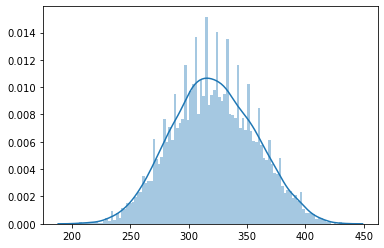

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(winner, bins = 100)

In [201]:
poll2020 = pd.read_csv('../data/raw/president_polls2.csv', parse_dates=['start_date'], 
                  usecols=['state', 'pollster', 'sample_size', 'start_date',  'candidate_party', 'pct'])
poll2020 = poll2020[(poll2020.candidate_party == 'DEM') | (poll2020.candidate_party == 'REP')  ]
poll2020['state'] = poll2020['state'].fillna('USA')
# pollusa = poll2020[poll2020['state'] == 'USA']
pollusa = poll2020.copy()
pollusa = pollusa.pivot_table(index = ['start_date', 'state'], columns = ['candidate_party'],
                    values = 'pct' , aggfunc = np.mean).reset_index().groupby([pd.Grouper(key='start_date', freq='M'), 'state'])


In [204]:
pollusa.mean()


candidate_party                  DEM        REP
start_date state                               
2018-11-30 Ohio            46.500000  45.250000
           USA             50.000000  43.000000
2018-12-31 USA             36.666667  36.666667
2019-01-31 Iowa            46.533333  52.200000
           Michigan        49.425000  41.600000
           New Hampshire   51.733333  41.033333
           North Carolina  46.333333  45.333333
           Texas           39.000000  52.000000
           USA             44.101984  43.020238
2019-02-28 Arizona         40.250000  48.250000
           Minnesota       52.000000  35.000000
           New Hampshire   50.828571  46.142857
           North Carolina  35.750000  44.500000
           South Carolina  44.522222  53.988889
           Texas           43.166667  48.083333
           USA             49.275000  44.370000
2019-03-31 Iowa            48.200000  49.728571
           Michigan        47.385714  46.754762
           Nevada          48.780000  51.220000
           Pennsylvania    48.663333  46.003333
           USA             41.060926  41.131204
           Wisconsin       49.902083  44.318750
2019-04-30 Florida         44.000000  48.000000
           Iowa            44.000000  49.000000
           Massachusetts   65.233333  34.766667
           Michigan        48.500000  41.500000
           Missouri        39.000000  51.250000
           Pennsylvania    48.500000  44.000000
           Texas           45.058333  50.441667
           USA             38.523363  41.306845
           Wisconsin       46.722222  43.055556
2019-05-31 Arizona         40.666667  46.166667
           Florida         48.360000  51.640000
           Michigan        48.766667  41.466667
           North Carolina  46.570000  49.930000
           North Dakota    39.000000  54.000000
           Pennsylvania    47.333333  44.000000
           Texas           44.571429  46.285714
           USA             41.793561  41.430682
2019-06-30 Florida         46.900000  44.816667
           Kentucky        32.000000  58.500000
           Maine           52.400000  47.600000
           Michigan        47.375000  42.250000
           New York        53.000000  35.000000
           North Carolina  46.600000  47.000000
           Pennsylvania    37.500000  44.000000
           South Carolina  34.250000  54.000000
           USA             41.944074  40.587672
           Wisconsin       43.250000  40.500000
2019-07-31 Alaska          34.200000  46.200000
           Arizona         50.000000  45.000000
           Colorado        51.000000  42.000000
           Kentucky        41.000000  53.000000
           Maine           50.000000  44.000000
           Michigan        43.500000  37.166667
           North Carolina  49.000000  45.000000
           North Dakota    34.000000  60.000000
           Ohio            45.166667  44.333333
           Texas           39.733333  37.883333
           USA             43.865885  42.960366
           Utah            35.142857  40.142857
           Washington      48.800000  32.160000
2019-08-31 Arizona         39.200000  43.800000
           California      59.142857  28.857143
           Colorado        53.880000  46.120000
           Michigan        48.500000  42.750000
           Nevada          44.714286  45.571429
           New Hampshire   49.800000  42.200000
           North Carolina  44.636364  44.000000
           Texas           42.833211  44.002442
           USA             43.234657  40.973310
           Wisconsin       47.625000  44.625000
2019-09-30 Arizona         39.750000  43.000000
           California      54.647368  31.457895
           Connecticut     48.960000  34.380000
           Florida         49.225000  50.775000
           Michigan        47.500000  38.500000
           Missouri        39.666667  53.666667
           Montana         46.940000  53.060000
           New Hampshire   52.180000  47.820000
           North Carolina  31.100000  38.880000
           Ohio 